# つくりながら学ぶ！深層強化学習 PyTorchによる実践プログラミング

## 迷路問題

前回は、迷路内をエージェントがランダムに行動する方策を実装した

今回は、エージェントが一直線にゴールへ向かうように方策を学習させる方法を考える

### 方策反復法と価値反復法
- **方策反復法**:
    - 行動の結果得られた報酬を元に、より良い報酬を得られた行動パターンをより多く取り入れるように方策を学習する
    - 迷路問題の場合でいうと、より早くゴールできたケースで採用した行動がより重要であると考え、その行動を多く取り入れるように学習する
- **価値反復法**:
    - 最終的な報酬から逆算して、各状態 $s$ に価値（優先度）をつけてエージェントを誘導するように方策を学習する
    - 迷路問題の場合でいうと、ゴールから逆算して、ゴールの1つ手前、2つ手前 ... の位置（状態）へエージェントを誘導する

ここは、方策反復法の具体的アルゴリズムである **方策勾配法 (Policy Gradient Method)** を実装する

### Softmax 関数
まず、方策パラメータ $\theta$ から、方策 $\pi_\theta(s, a)$ を求める関数について考える

前回は、単純に $\theta$ を割合に変換して方策 $\pi_\theta(s, a)$ を求めていた

```julia
policy(theta::Matrix) = theta ./ sum(theta, dims = 2)
                      = [
                          theta[row, col] / sum(theta[row, :])
                          for   row in 1:size(theta, 1),
                                col in 1:size(theta, 2)
                        ]
```

しかし、この単純な割合変換では $\theta$ がマイナス値をとったときにうまく計算できなくなってしまう

この問題を解決するためには、指数関数を導入して必ず正の値になるように変換すると良い

出力値の合計が 1.0 になる (各出力値が 0.0～1.0 になる) 指数関数としてよく使われるのが **Softmax 関数** (正規化指数関数) であり、以下のような式で表される

$$
    P(\theta_i) = \frac{e^{\beta\theta_i}}{\sum_{k=1}^n e^{\beta\theta_k}} (i = 1, 2, ..., n)
$$

ここで $n$ は選択可能な行動の種類数を示し、迷路問題の場合は上下左右の移動で 4 となる

また、$\theta$ にかかる係数 $\beta$ は逆温度と呼ばれ、逆温度が小さいほど行動がランダムになるという性質がある

In [1]:
# 関数の中身などを再起動不要で修正できるように Revise.jl を読み込んでおく
using Revise

include("./01_01-maze_module.jl")

theta_0 = Maze.theta_0

8×4 Matrix{Float64}:
 NaN      1.0    1.0  NaN
 NaN      1.0  NaN      1.0
 NaN      1.0    1.0    1.0
   1.0    1.0    1.0  NaN
 NaN    NaN      1.0    1.0
   1.0  NaN    NaN    NaN
   1.0  NaN    NaN    NaN
   1.0    1.0  NaN    NaN

In [2]:
using NaNStatistics

"""
    pi_theta_softmax(theta::Matrix{Union{Nothing, Number}}) = pi::Matrix{Number} (8x4)

方策パラメータ θ を行動方策 π に変換する Softmax 関数
"""
pi_theta_softmax(theta::Matrix) = begin
    # 逆温度β: 小さいほど行動がランダムになりやすい
    beta = 1.0

    # exp(βθ)::Matrix{Number} (8x4): ここでマイナス値も正規化される
    exp_theta = exp.(beta .* theta)

    # π_softmax(θ)
    ## 欠損値を無視して行ごとの列値合計を算出するために nansum(::Matrix, dims=2) を使う
    pi = exp_theta ./ nansum(exp_theta, dims=2)

    # 欠損値を 0.0 に変換して完了
    map(pi) do v isnan(v) ? 0.0 : v end
end

# 初期方策 π_0
pi_0 = pi_theta_softmax(theta_0)

8×4 Matrix{Float64}:
 0.0       0.5       0.5       0.0
 0.0       0.5       0.0       0.5
 0.0       0.333333  0.333333  0.333333
 0.333333  0.333333  0.333333  0.0
 0.0       0.0       0.5       0.5
 1.0       0.0       0.0       0.0
 1.0       0.0       0.0       0.0
 0.5       0.5       0.0       0.0

In [3]:
using Distributions

"""
    next_step(pi_n::Matrix{<:Number}, state::Int) = action_and_next_state::Tuple{Int, Int}

採用した行動 a と行動後の状態 s を求める関数

- `pi_n::Matrix{Number}`: 方策 π
- `state::Int`: 現在の状態 1..8
    - 1: S0, 2: S1, ... 8: S7
- `action_and_next_state::Tuple{Int, Int}`:
    - `(採用した行動, 行動後の状態)`
    - 行動: 1: UP, 2: RIGHT, 3: DOWN, 4: LEFT
"""
next_step(pi_n::Matrix{<:Number}, state::Int) = begin
    actions = [1, 2, 3, 4] # UP, RIGHT, DOWN, LEFT

    # 行動を決定
    ## Distributions.wsample(samples::Vector, weights::Vector) = choiced_sample
    ### samples の中から任意の値を1つ選択する。ただしその選択確率は weights で定められた重みによって決められる
    action = wsample(actions, pi_n[state, :])

    # 状態遷移
    # - 上: 状態 - 3
    # - 右: 状態 + 1
    # - 下: 状態 + 3
    # - 左: 状態 - 1
    state_transitions = Dict(
        1 => -3,
        2 => +1,
        3 => +3,
        4 => -1,
    )
    state_next = state + state_transitions[action]
    (action, state_next)
end

"""
    maze(pi_n::Matrix{<:Number}) = state_action_history::Vector{Tuple{Int, Int}}

迷路内をエージェントがゴールするまで移動させる関数

ゴールするまでにエージェントが通った状態と行動の軌跡 state_action_history を返す

- `state_action_history::Vector{Tuple{Int, Int}}`: `[(state1, action1), (state2, action2), ...]`
"""
maze(pi_n::Matrix) = begin
    # スタート地点: S0, ゴール地点: S8
    start, goal = 1, 9
    # 状態: 初期値 = S0
    state::Int = start
    # エージェントの移動記録: (状態, 行動)
    state_action_history::Vector{Tuple} = []

    # ゴールするまで step を繰り返す
    while state !== goal
        action, state_next = next_step(pi_n, state)
        push!(state_action_history, (state, action))
        state = state_next
    end

    # ゴール地点の記録
    push!(state_action_history, (state, NaN))

    state_action_history
end

# ゴールするまでエージェントを動かす
state_action_history = maze(pi_0)

27-element Vector{Tuple}:
 (1, 3)
 (4, 2)
 (5, 4)
 (4, 1)
 (1, 2)
 (2, 2)
 (3, 4)
 (2, 4)
 (1, 3)
 (4, 3)
 (7, 1)
 (4, 3)
 (7, 1)
 ⋮
 (4, 3)
 (7, 1)
 (4, 1)
 (1, 3)
 (4, 3)
 (7, 1)
 (4, 2)
 (5, 3)
 (8, 1)
 (5, 3)
 (8, 2)
 (9, NaN)

### 方策勾配法による方策の更新
次に、方策勾配法に従って方策を更新する部分を実装する

方策勾配法では以下の式に従ってパラメータ $\theta$ を更新する

$$
    \theta_{s_i, a_j} = \theta_{s_i, a_j} + \eta \cdot \Delta\theta_{s_i, a_j} \\
    \Delta\theta_{s_i, a_j} = \{N(s_i, a_j) + P(s_i, a_j)N(s_i, a)\} / T
$$

- $\theta_{s_i, a_j}$
    - 状態（迷路問題の場合は位置）$s_i$ で行動 $a_j$ を採用する確率を決めるパラメータ
- $\eta$
    - 学習係数: $\theta_{s_i, a_j}$ が1回の学習で更新される大きさ
    - $\eta$ が小さすぎると学習がなかなか進まないが、大きすぎるとうまく学習できない
- $N(s_i, a_j)$
    - 状態 $s_i$ で行動 $a_j$ を採用した回数
- $P(s_i, a_j)$
    - 現在の方策において、状態 $s_i$ で行動 $a_j$ を採用する確率
- $N(s_i, a)$
    - 状態 $s_i$ で何らかの行動をとった回数の合計
- $T$
    - ゴールまでにかかった総ステップ数

In [4]:
"""
    update_theta(theta_n::Matrix, pi_n::Matrix, state_action_history::Vector{Tuple}) = theta_next::Matrix

方策勾配法による方策パラメータの更新関数
"""
update_theta(theta_n::Matrix, pi_n::Matrix, state_action_history::Vector{Tuple}) = begin
    # 学習率 η: とりあえず 0.1 で試す
    eta = 0.1
    
    # ゴールまでの総ステップ数: ゴール地点のステップは除外
    T = length(state_action_history) - 1

    # Δθ の計算
    delta_theta = [
        isnan(theta_n[i, j]) ? NaN : (
            begin
                # 状態 = s_i である記録を取得
                SA_i = filter(SA -> SA[1] === i, state_action_history)

                # 状態 = s_i で 行動 = a_j をとった記録を取得
                SA_ij = filter(SA -> SA[1] === i && SA[2] === j, state_action_history)

                # N(s_i, a), N(s_i, a_j)
                N_i = length(SA_i)
                N_ij = length(SA_ij)

                # Δθ
                (N_ij + pi_n[i, j] * N_i) / T
            end
        )
        for i = 1:size(theta_n, 1), j = 1:size(theta_n, 2)
    ]

    # 更新されたθ
    theta_next = theta_n .+ eta .* delta_theta
    theta_next
end

update_theta

In [5]:
# 方策の更新
theta_next = update_theta(theta_0, pi_0, state_action_history)
pi_next = pi_theta_softmax(theta_next)

8×4 Matrix{Float64}:
 0.0       0.497115  0.502885  0.0
 0.0       0.5       0.0       0.5
 0.0       0.332906  0.332906  0.334189
 0.333332  0.332052  0.334616  0.0
 0.0       0.0       0.500962  0.499038
 1.0       0.0       0.0       0.0
 1.0       0.0       0.0       0.0
 0.5       0.5       0.0       0.0

In [6]:
"""
方策勾配法で迷路問題を解く

- 方策の変化が 10^-8 よりも小さくなったら学習完了とする
- 最大学習回数を 10,000 回とする
"""

using ProgressMeter

# 学習完了の方策変化しきい値
stop_epsilon = 10^-8

# 最大学習回数
max_count = 10_0000

# 初期 θ, π
theta_n = theta_0
pi_n = pi_0

# 学習記録: [(方策変化の絶対値和, ゴールまでのステップ数), ...]
records = Vector{Tuple}()

# 方策勾配法により学習ループする
@showprogress for _ = 1:max_count
    state_action_history = maze(pi_n) # 方策 π で迷路内を探索した履歴を取得
    theta_next = update_theta(theta_n, pi_n, state_action_history) # 方策パラメータ θ の更新
    pi_next = pi_theta_softmax(theta_next) # 方策 π の更新

    # 方策変化の絶対値和
    delta_pi = sum(abs.(pi_next .- pi_n))
    # 記録: (方策変化の絶対値和, ゴールまでのステップ数)
    push!(records, (delta_pi, length(state_action_history)))

    # 終了条件
    delta_pi < stop_epsilon && break

    # θ, π 更新
    theta_n, pi_n = theta_next, pi_next
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:0139m


In [8]:
# 学習記録確認
records

441-element Vector{Tuple}:
 (0.012968386055843828, 49)
 (0.013493805553645433, 15)
 (0.048740331645934054, 5)
 (0.03229601126185433, 7)
 (0.008879202827675792, 37)
 (0.02252714873097522, 13)
 (0.011713065218707519, 43)
 (0.024412906975073145, 13)
 (0.04175173546024591, 7)
 (0.00936653583742203, 45)
 (0.022434349060418912, 11)
 (0.014477954816171867, 33)
 (0.05080885618011449, 5)
 ⋮
 (1.729263169739216e-8, 5)
 (1.6449260287925727e-8, 5)
 (1.5647020498025688e-8, 5)
 (1.4883906122590942e-8, 5)
 (1.4158009833748658e-8, 5)
 (1.3467515688114925e-8, 5)
 (1.2810697079477549e-8, 5)
 (1.2185912359666444e-8, 5)
 (1.1591598455279885e-8, 5)
 (1.102626946953689e-8, 5)
 (1.0488512159744038e-8, 5)
 (9.976981172311394e-9, 5)

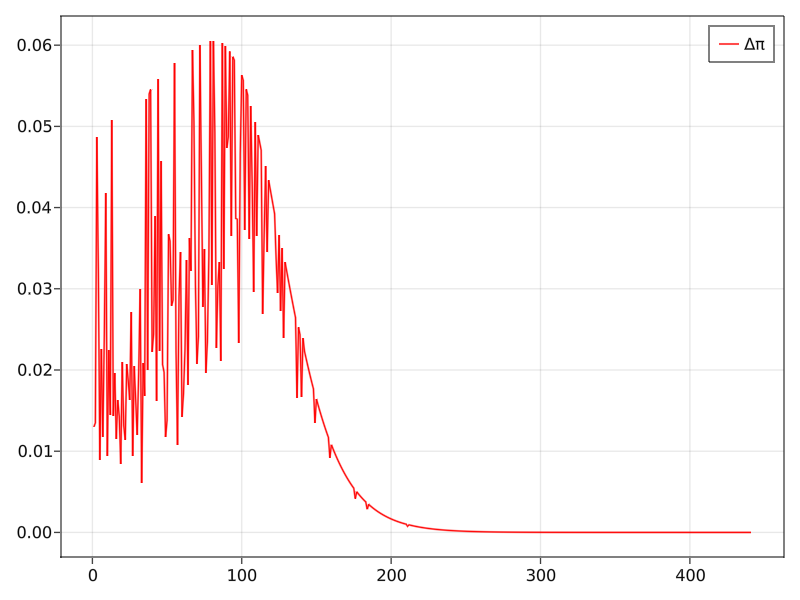

In [14]:
# 方策 π の変化絶対値総和とゴールまでのステップ数の学習記録をプロット
using GLMakie

x = 1:length(records)
lines(x, map(record -> record[1], records), color = :red, label = "Δπ")
axislegend() # 凡例表示
current_figure()

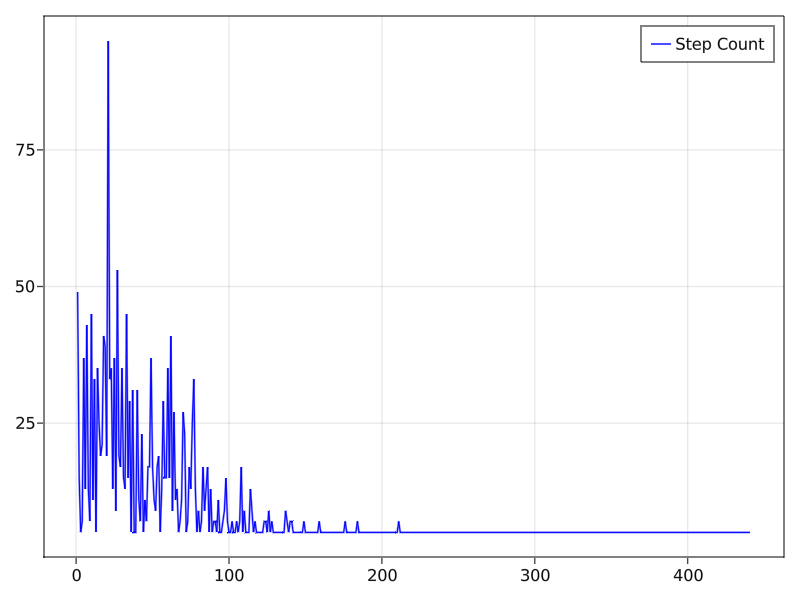

In [15]:
lines(x, map(record -> record[2], records), color = :blue, label = "Step Count")
axislegend()
current_figure()

In [17]:
# 最終的な方策を確認
round.(pi_n, digits = 3)

8×4 Matrix{Float64}:
 0.0  0.0    1.0    0.0
 0.0  0.471  0.0    0.529
 0.0  0.335  0.322  0.343
 0.0  1.0    0.0    0.0
 0.0  0.0    1.0    0.0
 1.0  0.0    0.0    0.0
 1.0  0.0    0.0    0.0
 0.0  1.0    0.0    0.0

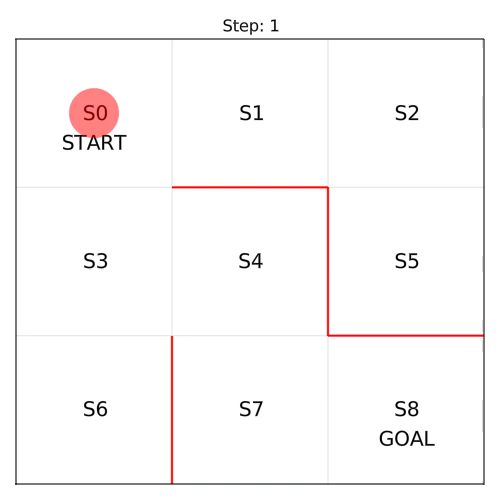

In [20]:
"""
    save_anim(save_filename::String, state_action_history::Vector{Tuple})

迷路内をエージェントがゴールするまで移動させた記録を動画ファイルに保存する関数
"""
save_anim(save_filename::String, state_action_history::Vector{Tuple}) = begin
    # 初期プロット描画
    fig, plt, ax, state_positions = Maze.maze_plot()
    agent_pos = Maze.agent_plot!(plt, state_positions[1])

    # 動画作成
    n_states = length(state_action_history)
    record(fig, save_filename, 1:n_states;
        # state_history を5秒でアニメーションさせるように framerate 設定
        framerate = ceil(Int, n_states / 5)
    ) do frame
        # エージェント位置更新
        agent_pos[] = state_positions[state_action_history[frame][1]]

        # プロットタイトル更新
        ax.title = "Step: $frame"
    end
end

save_anim("img/01_02-policy_gradient.gif", maze(pi_n))
display("image/gif", read("img/01_02-policy_gradient.gif"))

上記の通り、方策勾配法による学習により、エージェントが一直線にゴールに向かうように訓練することができた

---

[今回の実装モジュール](./01_02-maze_module.jl)

```julia
include("01_02-maze_module.jl")
using .Maze
using .Maze: GLMakie

records, theta_n, pi_n = train(theta_0)

# 学習曲線 (方策変化の絶対値和)
lines(getindex.(records, 1))

# 学習曲線 (ゴールまでのステップ数)
lines(getindex.(records, 2))

# 学習後のエージェントの行動を動画化
state_action_history = maze(pi_n)
save_anim("01_02-maze.gif", state_action_history)
```